In [1]:
import sys
import os
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

from torch.utils.data import DataLoader

import pytorch_lightning as pl

In [2]:
sys.path.append('../modules/')
import dataset as D
import model as M
import network as N
import util

In [3]:
transforms = A.Compose([
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.RandomRotate90(),
    A.ShiftScaleRotate()
])

In [4]:
reload(D)

<module 'dataset' from '../modules/dataset.py'>

In [5]:
%%time
wt_dataset = D.FramesDataset(path_data='../../data',
                             dir_frames='frames_separated',
                             select='wt',
                             transforms=transforms,
                             )

Read cached metainfo from ../../data/metainfo_replicate*_wt.csv
CPU times: user 567 ms, sys: 96.4 ms, total: 663 ms
Wall time: 933 ms


In [6]:
train_sampler, valid_sampler = wt_dataset.get_train_valid_samplers()
train_loader = DataLoader(wt_dataset, batch_size=512, sampler=train_sampler, num_workers=16)
valid_loader = DataLoader(wt_dataset, batch_size=512, sampler=valid_sampler, num_workers=16)

In [7]:
len(wt_dataset), len(train_sampler), len(valid_sampler)

(268257, 198400, 69857)

In [159]:
reload(N)
reload(M)

<module 'model' from '../modules/model.py'>

In [160]:
model = M.LitModel(network=N.resnet18(n_classes=wt_dataset.n_classes, base_channels=16))

In [29]:
trainer = pl.Trainer(gpus=1, max_epochs=50, )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [4]


In [12]:
trainer.fit(model, train_loader, valid_loader)

Set SLURM handle signals.

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResidualNetwork  | 712 K 
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     


Saving latest checkpoint..


1

In [161]:
state = torch.load('./lightning_logs/version_11975893/checkpoints/epoch=47.ckpt')
state_dict = state['state_dict']
for k in list(state_dict.keys()):
    state_dict[k.replace('network', 'features').replace('model', 'network')] = state_dict.pop(k)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [131]:
predictions, features, y = model.inference(valid_loader)

In [140]:
util.accuracy(y, predictions, top=1), util.accuracy(y, predictions, top=5), util.accuracy(y, predictions, top=10)

(0.4340438324004753, 0.7033081867243083, 0.7997051118713944)

In [151]:
reload(D)

<module 'dataset' from '../modules/dataset.py'>

In [152]:
pair_dataset = D.FramesDataset(select=['POR1', 'POR2'])
pair_dataloader = DataLoader(pair_dataset, batch_size=256, shuffle=False, num_workers=16)

Read cached metainfo from ../data/metainfo_replicate*_['POR1', 'POR2'].csv


In [153]:
pair_dataset.metainfo.head()

,URL,replicate,cell_id,file,Row,Column,Field,R-C,GFP,natMX4,pairs,label,class
0,5021001,frames,0000.npy,../data/frames/replicate1/005021001/0000.npy,5,21,1,5-21,POR2,NaN,POR2-POR1,POR2-GFP POR1-WT,1
1,5021001,frames,0001.npy,../data/frames/replicate1/005021001/0001.npy,5,21,1,5-21,POR2,NaN,POR2-POR1,POR2-GFP POR1-WT,1
2,5021001,frames,0002.npy,../data/frames/replicate1/005021001/0002.npy,5,21,1,5-21,POR2,NaN,POR2-POR1,POR2-GFP POR1-WT,1
3,5021001,frames,0003.npy,../data/frames/replicate1/005021001/0003.npy,5,21,1,5-21,POR2,NaN,POR2-POR1,POR2-GFP POR1-WT,1
4,5021001,frames,0004.npy,../data/frames/replicate1/005021001/0004.npy,5,21,1,5-21,POR2,NaN,POR2-POR1,POR2-GFP POR1-WT,1


In [154]:
len(pair_dataset)

11165

In [162]:
predictions, features, y = model.inference(pair_dataloader)

In [166]:
from sklearn.decomposition import PCA
tfm = PCA(n_components=2)
features_tfm = tfm.fit_transform(features)

In [171]:
import pandas as pd
import seaborn as sns

In [169]:
df = pd.DataFrame({'x': features_tfm[:,0], 
                   'y': features_tfm[:,1],
                   'label': pair_dataset.metainfo.label})

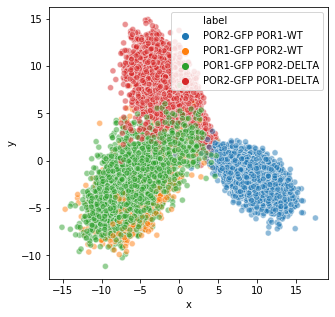

In [172]:
plt.figure(figsize=(5,5))
sns.scatterplot(data=df, x='x', y='y', hue='label', alpha=0.5)
plt.show()